# Predicting NBA Hall of Fame Odds
### What makes a hall of fame career?
### Statsheet:
- Points, rebounds, assists, steals, blocks (total and per game)
- Shooting splits (FG%, 3P%, FT%)
### Accolades and Achievements:
- ***Rings***
- MVP and Finals MVP awards
- All-NBA, All-Defensive, All-Star selections
- DPOY and ROTY awards
### Longevity
- Seasons played
- Games played

## Imports, constants, and helper functions

In [73]:
# API
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats, playerawards

# Data
import pandas as pd
import numpy as np
import random

# AI/ML
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [74]:
# return an nba player given their name
# str (name) -> dict (player info)
def find_player(name):
    all_players = players.get_players()
    player = [p for p in all_players if p['full_name'].upper() == name.upper()]
    if player:
        return player[0]
    else:
        raise ValueError("Player not found")

In [75]:
# declare constants
csv_filename = 'final_hofdataset.csv'
included = ["DRAFT_YEAR", "SP", "GP", "PTS", "REB", "AST", "STL", "BLK", "PPG", "RPG", "APG", "SPG", "BPG", 
          "FG_PCT", "FG3_PCT", "FT_PCT", "RINGS", "FMVP", "MVP", "ALL_NBA", "ALL_STAR", "ALL_DEF", "ROTY", "DPOY"]
career_totals_list = ["GP", "PTS", "REB", "AST", "STL", "BLK"]
avgs_tl = {"PPG": "PTS", "RPG": "REB", "APG": "AST", "SPG": "STL", "BPG": "BLK"}
awards_tl = {"RINGS": "NBA Champion",
          "FMVP": "NBA Finals Most Valuable Player",
          "MVP": "NBA Most Valuable Player", 
          "ALL_NBA": "All-NBA",
          "ALL_STAR": "NBA All-Star",
          "ALL_DEF": "All-Defensive Team",
          "ROTY": "NBA Rookie of the Year",
          "DPOY": "NBA Defensive Player of the Year",
          "HOF": "Hall of Fame Inductee"}
awards_tl = dict((v,k) for k,v in awards_tl.items())

In [76]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Step 1: Gathering Data
### Each player has a dictionary with the following:
- Career totals
- Career averages
- Shooting splits
- Awards (incl. Hall of Fame, our independent variable)

In [77]:
# return a dictionary with a given player's inputs to the ANN
def get_inputs(name):
    player = find_player(name)
    career = playercareerstats.PlayerCareerStats(player_id=player['id'])
    lodf = career.get_data_frames()
    career_info = lodf[1]
    career_by_season = lodf[0]
    awards = {"RINGS": 0, "FMVP": 0, "MVP": 0, "ALL_NBA": 0, "ALL_STAR": 0, "ALL_DEF": 0, "ROTY": 0, 
              "DPOY": 0, "HOF": 0}
    input_stats = {}
    
    # Add career total stats to dictionary
    input_stats["FULL_NAME"] = name
    try:
        draft_yr = int(career_by_season['SEASON_ID'].iloc[0][:4])
        ret_yr = int(career_by_season['SEASON_ID'].iloc[-1][:4])
    except:
        return {}
    input_stats["DRAFT_YEAR"] = draft_yr
    input_stats["RET_YEAR"] = ret_yr
    input_stats["SP"] = ret_yr - draft_yr + 1
    
    if draft_yr < 1979:
        input_stats["OLDHEAD"] = 1
        input_stats["MIDDLE"] = 0
        input_stats["MODERN"] = 0
    elif draft_yr < 2000:
        input_stats["OLDHEAD"] = 0
        input_stats["MIDDLE"] = 1
        input_stats["MODERN"] = 0
    else:
        input_stats["OLDHEAD"] = 0
        input_stats["MIDDLE"] = 0
        input_stats["MODERN"] = 1
    
    for stat in career_totals_list:
        if stat in ["STL", "BLK"]:
            input_stats[stat] = career_info[stat][0] if not input_stats["OLDHEAD"] else 0
        else:
            input_stats[stat] = career_info[stat][0]
    
    # Add career average stats to dictionary
    for avg in avgs_tl:
        if avg in ["SPG", "BPG"]:
            input_stats[avg] = round(career_info[avgs_tl[avg]][0] / career_info['GP'][0], 1) if not input_stats["OLDHEAD"] else 0.0
        else:
            try:
                input_stats[avg] = round(career_info[avgs_tl[avg]][0] / career_info['GP'][0], 1)
            except:
                input_stats[avg] = 0.0
        
    # Add career shooting splits to dictionary
    for pct in ["FG_PCT", "FG3_PCT", "FT_PCT"]:
        if pct == 'FG3_PCT':
            input_stats[pct] = round(career_info[pct][0], 3) if not input_stats["OLDHEAD"] else 0.0
        else:
            input_stats[pct] = round(career_info[pct][0], 3)
    
    # Add relevant awards to dictionary
    won = playerawards.PlayerAwards(player_id=player['id']).get_data_frames()[0]
    for row in won['DESCRIPTION']:
        if row in awards_tl.keys():
            awards[awards_tl[row]] += 1
            
    return dict(**input_stats, **awards)

## Step 2: Build the dataset
We want to make a **pandas dataframe** (think python spreadsheet) with many players' info  
*Note: only non-active players should be added. *We don't know yet know if an active player will make the HOF.*

In [78]:
# generate_dataframe : num~ -> DataFrame
# Fetches player data at random, inputting it into a DataFrame
def generate_dataframe(test_size=100):
    all_players = players.get_players()
    random.shuffle(all_players)
    only_retired = [player for player in all_players if not player['is_active']]
    ls = []
    count = 0
    for player in only_retired[:test_size]:
        try:
            ls.append(get_inputs(player['full_name']))
        except:
            print(f"---\n\n\n\n----------\n\n FAIL\n\n------------\n\n\n\n\n\n\n\n---")
            try:
                print(f"Error adding {player['full_name']}")
            except:
                print("Metta world peace")
                continue
        count += 1
        print(f"Added {count}/{test_size} players")
    
    return pd.DataFrame(ls)

### Generate new dataset and save as csv

In [79]:
#dataset = generate_dataframe(4330)
#dataset.to_csv(csv_filename, index=False)

### Or read from saved csv

In [80]:
dataset = pd.read_csv(csv_filename)

## Step 3: Data Preprocessing

### Filtering missing values

In [81]:
dataset = dataset[dataset["DRAFT_YEAR"] >= 1960]
dataset = dataset[dataset["RET_YEAR"] < 2021]

In [82]:
dataset.dropna(how='any', inplace=True)

In [83]:
dataset = dataset.sample(frac=1)

### Formatting to fit columns

In [84]:
X = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1:].values
names = dataset.iloc[:, 0].values

In [85]:
# optional: drop columns
# names = dataset.iloc[:, 0].values
# dataset.drop(labels=["FULL_NAME", "DRAFT_YEAR", "RET_YEAR"], axis=1, inplace=True)
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1:].values

### Split into training and test sets

In [86]:
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(X, y, names, test_size = 0.3, random_state = 69)

### Feature Scaling

In [87]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Step 4: Build and train the ANN

In [88]:
ann = Sequential()
ann.add(Dense(units = 12, activation='relu'))
ann.add(Dense(units = 6, activation='relu'))
ann.add(Dense(units = 1, activation='sigmoid'))

In [89]:
metrics = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

In [90]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = metrics)

In [91]:
ann.fit(X_train, y_train, batch_size = 128, epochs = 50)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 583us/step - Brier score: 0.2486 - accuracy: 0.5351 - cross entropy: 0.6912 - fn: 13.0000 - fp: 576.7500 - loss: 0.6910 - precision: 0.0371 - recall: 0.5855 - tn: 713.5500 - tp: 26.9000         
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - Brier score: 0.1843 - accuracy: 0.7803 - cross entropy: 0.5519 - fn: 14.0500 - fp: 264.3000 - loss: 0.5518 - precision: 0.1102 - recall: 0.7171 - tn: 1019.8500 - tp: 32.0000
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - Brier score: 0.1417 - accuracy: 0.8699 - cross entropy: 0.4551 - fn: 15.9000 - fp: 146.4500 - loss: 0.4550 - precision: 0.1453 - recall: 0.5943 - tn: 1139.8500 - tp: 28.0000
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - Brier score: 0.1076 - accuracy: 0.9263 - cross entropy: 0.3737 - fn: 17.6500 - fp: 74.3500 - loss: 0.3736 - precision: 0.2180 - recall: 0.5418 - tn: 1215.6500 - tp: 22.5500
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - Brier score: 0.0829 - accur

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - Brier score: 0.0083 - accuracy: 0.9888 - cross entropy: 0.0376 - fn: 11.1500 - fp: 2.5000 - loss: 0.0378 - precision: 0.9364 - recall: 0.7135 - tn: 1285.1000 - tp: 31.4500
Epoch 33/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - Brier score: 0.0056 - accuracy: 0.9940 - cross entropy: 0.0287 - fn: 6.9000 - fp: 2.8500 - loss: 0.0286 - precision: 0.9374 - recall: 0.8758 - tn: 1284.4000 - tp: 36.0500     
Epoch 34/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - Brier score: 0.0077 - accuracy: 0.9907 - cross entropy: 0.0348 - fn: 8.5500 - fp: 3.1500 - loss: 0.0347 - precision: 0.9279 - recall: 0.7718 - tn: 1285.8000 - tp: 32.7000 
Epoch 35/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - Brier score: 0.0068 - accuracy: 0.9912 - cross entropy: 0.0328 - fn: 8.1000 - fp: 3.5000 - loss: 0.0328 - precision: 0.9016 - recall: 0.8240 - tn: 1284.8000 - tp: 33.8000     
Epoch 36/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - Brier score: 0.0076 - accuracy: 0.9906 - 

## Model Performance
### Test dataset (retired players)
*Confusion Matrix lets us see hall of fame snubs and imposters*

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


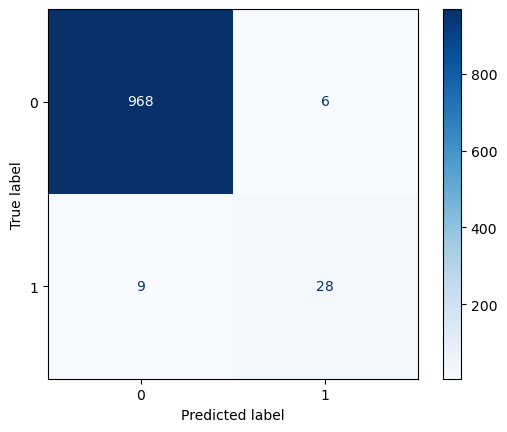

In [92]:
y_pred = (ann.predict(X_test) > 0.5).astype("int32")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [53]:
snubbed = names_test[(y_pred.flatten() == 1) & (y_test.flatten() == 0)]
undeserved = names_test[(y_pred.flatten() == 0) & (y_test.flatten() == 1)]

print("Snubbed:")
for name in snubbed:
    print(name)
    
print("\nUndeserved:")
for name in undeserved:
    print(name)

Snubbed:
Bob Dandridge
Brad Daugherty

Undeserved:
Nate Thurmond
Charlie Scott
Bobby Jones
John Thompson
Vlade Divac
Arvydas Sabonis
Dan Issel
George McGinnis
Lou Dampier
Walt Bellamy
Manu Ginobili
Reggie Miller
Drazen Petrovic


## HOF Probabilities for Active Players

### Test dataset (active players)
Using a separate database, we can make predictions about current NBA players

In [54]:
dataset_active = pd.read_csv('active_hofdataset.csv')
dataset_active.dropna(how='any', inplace=True)
names_active = dataset_active.iloc[:, 0]
X_active = dataset_active.iloc[:, 3:-1]
y_active = dataset_active.iloc[:, -1:]

### Feature Scaling

In [55]:
X_active = sc.transform(X_active)

/opt/anaconda3/envs/cogo1/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


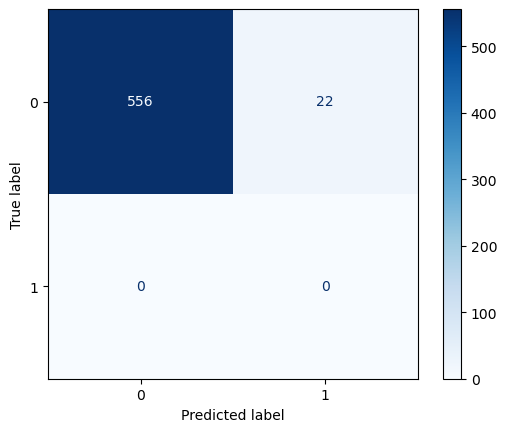

In [56]:
y_probs_active = ann.predict(X_active)

y_pred_active = (y_probs_active > 0.5).astype("int32")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_active, y_pred_active))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [57]:
prob_df = pd.DataFrame(zip(names_active, np.array(y_probs_active)))
prob_df.sort_values(by=1, inplace=True, ascending=False)
prob_df

,0,1
77,LeBron James,[0.99999994]
118,Stephen Curry,[0.99941474]
354,Kevin Durant,[0.99929017]
572,Giannis Antetokounmpo,[0.9992097]
142,Nikola Jokic,[0.9988199]
328,Chris Paul,[0.99870235]
93,Russell Westbrook,[0.9970691]
483,James Harden,[0.992908]
116,Kawhi Leonard,[0.99116504]
149,Joel Embiid,[0.98804647]
